# Validation for a TiO2/SiO2 Bragg mirror

Author: O. Castany, C. Molinaro, M. Müller

This notebook validates the optical response of a 1D Bragg mirror composed of alternating layers of TiO₂ and SiO₂ using:
- An analytical model based on Fresnel coefficients and transfer matrix recursion.
- Numerical simulation with the pyElli package.

In [1]:
import numpy as np
import elli
import elli.plot as elliplot
import matplotlib.pyplot as plt
from scipy.constants import pi

## Structure definition

### Front and back materials

In [2]:
n_a = 1.0   # Refractive index of air (ambient)
n_g = 1.5   # Refractive index of glass (substrate)

air = elli.ConstantRefractiveIndex(n_a).get_mat()
glass = elli.ConstantRefractiveIndex(n_g).get_mat()

### Materials for a SiO2/TiO2 Bragg mirror

In [3]:
lbda0 = 1550  # Central wavelength in nm
k0 = 2 * pi / lbda0

# Approximate refractive indices at 1550 nm
n_SiO2 = 1.47
n_TiO2 = 2.23 + 1j * 5.2e-4

SiO2 = elli.ConstantRefractiveIndex(n_SiO2).get_mat()
TiO2 = elli.ConstantRefractiveIndex(n_TiO2).get_mat()

### Layers and Structure

In [4]:
# Compute quarter-wave optical thicknesses
d_SiO2 = elli.get_qwp_thickness(SiO2, lbda0)
d_TiO2 = elli.get_qwp_thickness(TiO2, lbda0)

# Build individual layers
L_SiO2 = elli.Layer(SiO2, d_SiO2)
L_TiO2 = elli.Layer(TiO2, d_TiO2)

# Stack definition: TiO2/SiO2 repeated 4 times
Layerstack = elli.RepeatedLayers([L_TiO2, L_SiO2], 4, 0, 0)

# Total number of interfaces
N = 2 * Layerstack.repetitions + 1

# Complete structure: Air / {TiO2 / SiO2}ⁿ / Glass
s = elli.Structure(air, [Layerstack], glass)

## Analytical calculation

This section implements a recursive transfer matrix method to calculate the amplitude reflection coefficient using Fresnel coefficients.

In [5]:
# Define refractive index profile
n = np.ones(N + 1, dtype=complex)
n[0] = n_a
n[1::2] = n_TiO2  # TiO2 layers at odd positions
n[2::2] = n_SiO2  # SiO2 layers at even positions
n[-1] = n_g
n.shape = (-1, 1)

# Define thickness profile (same order as n, d[0] unused)
d = np.ones(N + 1)
d[1::2] = L_TiO2.thickness
d[2::2] = L_SiO2.thickness

# Wavelength range
(lbda1, lbda2) = (1100, 2500)  # in nm
lbda_list = np.linspace(lbda1, lbda2, 200)


def ReflectionCoeff(incidence_angle=0.0, polarisation="s"):
    """Compute the amplitude reflection coefficient at a given angle and polarization."""
    Kx = n[0] * np.sin(incidence_angle)
    kz = 2 * pi / lbda_list * np.sqrt(n**2 - (Kx) ** 2)

    # Reflexion coefficient r_{k,k+1} for a single interface
    #    polarisation s:
    #    r_ab(p) = r_{p,p+1} = (kz(p)-kz(p+1))/(kz(p)+kz(p+1))
    #    polarisation p:
    #    r_ab(p) = r_{p,p+1} = (kz(p)*n[p+1]**2-kz(p+1)*n[p]**2) \
    #                          /(kz(p)*n[p]**2+kz(p+1)*n[p+1]**2)
    if polarisation == "s":
        r_ab = (-np.diff(kz, axis=0)) / (kz[:-1] + kz[1:])
    elif polarisation == "p":
        r_ab = (kz[:-1] * (n[1:]) ** 2 - kz[1:] * (n[:-1]) ** 2) / (
            kz[:-1] * (n[1:]) ** 2 + kz[1:] * (n[:-1]) ** 2
        )

    # Local function definition for recursive calculation
    def U(k):
        """Returns reflection coefficient U(k) = r_{k, {k+1,...,N}}

        Used recursively.
        """
        p = k + 1
        if p == N:
            res = r_ab[N - 1]
        else:
            res = (r_ab[p - 1] + U(p) * np.exp(2j * kz[p] * d[p])) / (
                1 + r_ab[p - 1] * U(p) * np.exp(2j * kz[p] * d[p])
            )
        return res

    return U(0)


# Power reflexion coefficient for different incidence angles and polarisations
R_th_ss_0 = (np.abs(ReflectionCoeff(0, "s"))) ** 2      # Normal incidence, s-pol
R_th_ss = (np.abs(ReflectionCoeff(pi / 4, "s"))) ** 2   # 45° incidence, s-pol
R_th_pp = (np.abs(ReflectionCoeff(pi / 4, "p"))) ** 2   # 45° incidence, p-pol

## Calculation with pyElli

- Uses pyElli.Structure.evaluate() to simulate the multilayer response numerically,
- Returns the reflectance (R_ss, R_pp) at the desired wavelengths and angles,
- Automatically accounts for multiple reflections and complex indices.

In [6]:
# Incidence angle Phi_i = 0, 's' polarization
data = s.evaluate(lbda_list, 0)

R_ss_0 = data.R_ss

# Incidence angle Phi_i = pi/4, 's' and 'p' polarizations
data2 = s.evaluate(lbda_list, np.rad2deg(pi / 4))

R_ss = data2.R_ss
R_pp = data2.R_pp

## Plotting

Plots both analytical and numerical reflectance spectra:
 - Lines: pyElli numerical results,
 - Markers (×): theoretical recursive results,
 - Uses elliplot.draw_structure() to illustrate the layer stack alongside the spectra.

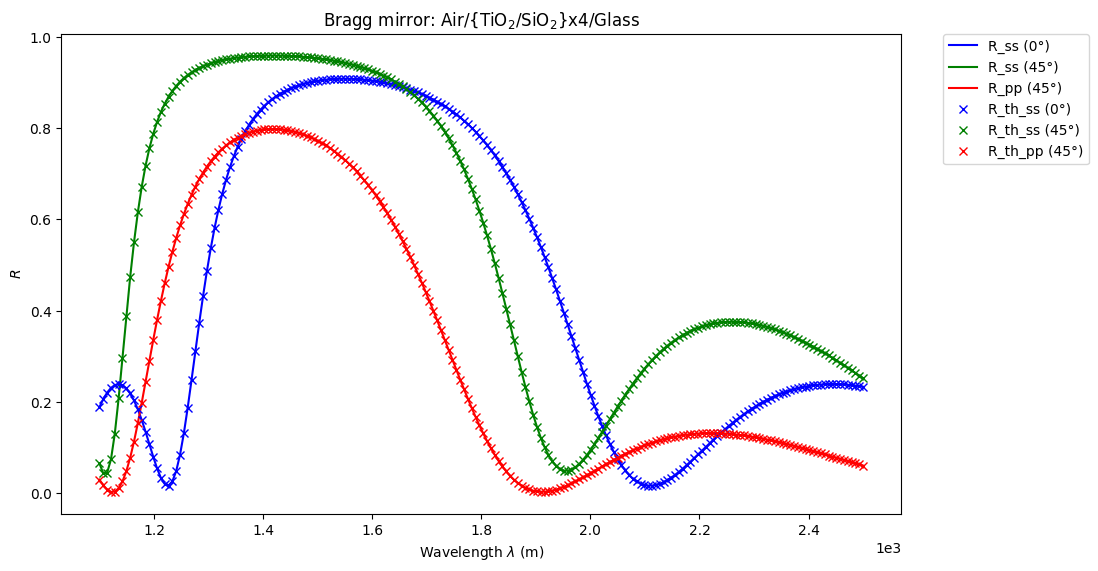

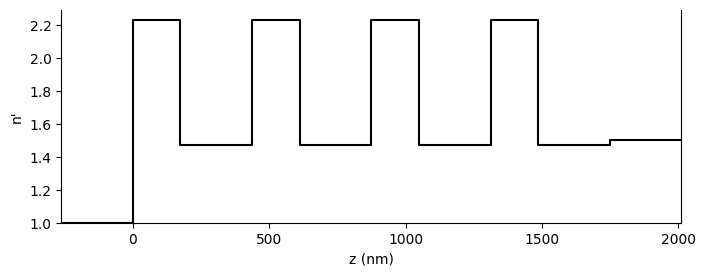

In [7]:
fig = plt.figure(figsize=(12.0, 6.0))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", "bgr")
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8])

d = np.vstack((R_ss_0, R_ss, R_pp)).T
lines1 = ax.plot(lbda_list, d)
legend1 = ("R_ss (0°)", "R_ss (45°)", "R_pp (45°)")

d = np.vstack((R_th_ss_0, R_th_ss, R_th_pp)).T
lines2 = ax.plot(lbda_list, d, "x")
legend2 = ("R_th_ss (0°)", "R_th_ss (45°)", "R_th_pp (45°)")

ax.legend(
    lines1 + lines2,
    legend1 + legend2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

ax.set_title(
    r"Bragg mirror: Air/{TiO$_2$/SiO$_2$}x" + str(Layerstack.repetitions) + "/Glass"
)
ax.set_xlabel(r"Wavelength $\lambda$ (m)")
ax.set_ylabel(r"$R$")
fmt = ax.xaxis.get_major_formatter()
fmt.set_powerlimits((-3, 3))

elliplot.draw_structure(s)
plt.show()